In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
ma=pd.read_pickle('./muscle/muscle_ma.pkl')
test=pd.read_pickle('./muscle/muscle_test.pkl')
#保存前にいらないパラメータ消したのに入ってる、なんでだろう？？？？

In [25]:
#とりあえずもう一回消そう
drop_columns=['day','precipitation','temperature','steps','sunlight']
data=[ma,test]

In [26]:
ma=ma.drop(drop_columns,axis=1)
test=test.drop(drop_columns,axis=1)
#week=2（火曜日）は休みに設定してるから、２のデータを消したいな、どうすればいいの？？

In [27]:
ma1=ma.loc[ma["week"] != 2,["do","holiday","week","weather","temperature_band","steps_band","sunlight_band"]]
#正解test.loc[test[""]~→test.loc[ma[""]]~になってた,後々全部にweek=2が入ってた

In [28]:
ma1.head(6)#ちゃんと消えてるね

,do,holiday,week,weather,temperature_band,steps_band,sunlight_band
0,1,0,4,0,0,2,3
1,1,0,5,1,0,1,1
2,1,0,6,2,0,0,0
3,1,0,7,0,0,1,3
4,1,0,1,0,0,2,3
6,1,0,3,0,0,1,3


In [29]:
test1=test.loc[ma["week"] != 2,["do","holiday","week","weather","temperature_band","steps_band","sunlight_band"]]

学習するデータと、予測したいデータの設定

In [30]:
ma1_X=ma1[ma1.columns[1:]]#学習するデータの説明変数
ma1_Y=ma1[ma1.columns[0]]#学習するデータの目的変数
test1_X=test1[test1.columns[1:]]#予測するデータの説明変数
test1_Y=test1[test1.columns[0]]#予測するデータの目的変数

決定木で分析

In [31]:
from sklearn import tree
model=tree.DecisionTreeClassifier()
model.fit(ma1_X,ma1_Y)
predict=model.predict(test1_X)
from sklearn import metrics
print("判別率",metrics.accuracy_score(predict,test1_Y))

判別率 0.6037735849056604


ランダムフォレストで分析

In [32]:
from sklearn.ensemble import RandomForestClassifier
model=tree.DecisionTreeClassifier()
model.fit(ma1_X,ma1_Y)
predict=model.predict(test1_X)
from sklearn import metrics
print("判別率",metrics.accuracy_score(predict,test1_Y))

判別率 0.5943396226415094


/Users/isyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='feature_importances'>

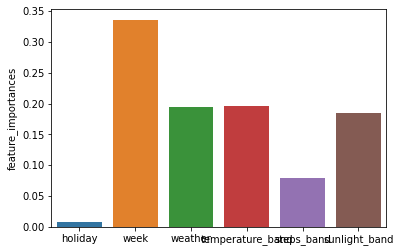

In [33]:
feature_importances=pd.DataFrame({"feature_importances":model.feature_importances_})
sns.barplot(ma1_X.columns,feature_importances["feature_importances"])
#判別するのに一番寄与したパラメータがどれかを観る

決定木、ランダムフォレスト分析ごとに5％くらい差ができる⇨もっと精度を上げられないだろうか？

６ヶ月４ヶ月で分けないで、分け方を変えてみよう

In [34]:
muscle=pd.concat([ma1,test1],ignore_index=True)

In [37]:
from sklearn.model_selection import train_test_split
mu_muscle,mu_test=train_test_split(muscle,test_size=0.3,random_state=1234)
#データを７：３にランダムで分ける
#データ分割の関数は必ずtrain_test_split！！！！！

In [38]:
mu_muscle_X=mu_muscle[muscle.columns[1:]]#[1]になってた
mu_muscle_Y=mu_muscle[muscle.columns[0]]#これのせいで"do"を1列目に持ってくる羽目になった
mu_test_X=mu_test[muscle.columns[1:]]
mu_test_Y=mu_test[muscle.columns[0]]
#学習、予測データの設定

決定木、ランダムフォレスト

In [39]:
from sklearn import tree
model=tree.DecisionTreeClassifier()
model.fit(mu_muscle_X,mu_muscle_Y)
predict=model.predict(mu_test_X)
from sklearn import metrics
print("判別率",metrics.accuracy_score(predict,mu_test_Y))

判別率 0.7


In [41]:
from sklearn.ensemble import RandomForestClassifier
model=tree.DecisionTreeClassifier()
model.fit(mu_muscle_X,mu_muscle_Y)
predict=model.predict(mu_test_X)
from sklearn import metrics
print("判別率",metrics.accuracy_score(predict,mu_test_Y))

判別率 0.725


どっちも前よりマシになってる

網羅的に分割してみよう

k分割交差検証

In [42]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
kf=KFold(n_splits=5,random_state=30,shuffle=True)
x=muscle[muscle.columns[1:]]
y=muscle["do"]
cv_result=cross_val_score(model, x , y, cv=kf)
print(cv_result)
print("平均精度:{}".format(cv_result.mean()))

[0.66037736 0.58490566 0.73584906 0.56603774 0.71698113]
平均精度:0.6528301886792451


グリッドサーチ

In [43]:
from sklearn.model_selection import GridSearchCV
param={'n_estimators':range(100,1000,100)}
GS_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                  param_grid=param,
                  verbose=True,
                  cv=5)
GS_rf.fit(x,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': range(100, 1000, 100)}, verbose=True)

In [44]:
print("ベストなスコア:{}".format(GS_rf.best_score_))
print("最適なパラメータ:{}".format(GS_rf.best_estimator_))

ベストなスコア:0.6641509433962264
最適なパラメータ:RandomForestClassifier(n_estimators=200, random_state=0)


決定木が200本の時に最適

/Users/isyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='feature_importances'>

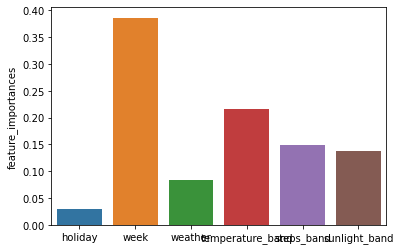

In [45]:
feature_importances=pd.DataFrame({"feature_importances":model.feature_importances_})
sns.barplot(mu_muscle_X.columns,feature_importances["feature_importances"])

何曜日か、気温、歩数、日照時間の順に、判別の寄与率が高い